In [ ]:
import pandas as pd
import os

# Путь к CSV файлу в корневой директории с ноутбуком
csv_file_path = os.path.join(os.getcwd(), 'all_wells_data.csv')

# Загружаем CSV файл в DataFrame
df = pd.read_csv(csv_file_path)

# Преобразуем все столбцы, кроме 'well', в числовые значения с запятой
# Для этого используем apply и преобразуем строковые значения в числа с запятой
columns_to_convert = df.columns[df.columns != 'well']  # Выбираем все колонки, кроме 'well'

# Применяем преобразование к каждому столбцу
for column in columns_to_convert:
    df[column] = df[column].apply(lambda x: float(x.replace(",", ".")) if isinstance(x, str) else x)

# Проверим, что столбцы заменены корректно
print(df.info())
print(df.head())

In [35]:
# Удаляем строки, где GK_XM равно -999.25
df = df[df['GK_XM'] != -999.25]

# Для остальных признаков заменяем -999.25 на медиану
for column in ["ГЛУБИНА", "AK_XM", "GK_XM", "NGK_XM", "L_IGR_XM"]:
    median_value = df[column][df[column] != -999.25].median()
    df[column] = df[column].replace(-999.25, median_value)

# Исключаем колонку TVDSS
df = df.drop(columns=["TVDSS"])

# Выводим информацию о DataFrame после изменений
print(df.info())

# Пример вывода первых строк после преобразований
print(df.head())


<class 'pandas.core.frame.DataFrame'>
Index: 331891 entries, 1818 to 4593524
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ГЛУБИНА   331891 non-null  float64
 1   AK_XM     331891 non-null  float64
 2   GK_XM     331891 non-null  float64
 3   NGK_XM    331891 non-null  float64
 4   L_IGR_XM  331891 non-null  float64
 5   well      331891 non-null  object 
dtypes: float64(5), object(1)
memory usage: 17.7+ MB
None
      ГЛУБИНА   AK_XM  GK_XM  NGK_XM  L_IGR_XM  well
1818   2291.7  226.02  7.420   1.530       0.0  1002
1819   2291.8  226.02  7.026   1.541       0.0  1002
1820   2291.9  226.02  7.243   1.505       0.0  1002
1821   2292.0  226.02  7.459   1.469       0.0  1002
1822   2292.1  226.02  7.611   1.408       0.0  1002


Информация по кластерам:
                                                      well
Cluster                                                   
0        [1002, 1002, 1002, 1002, 1002, 1002, 1002, 100...
1        [1108_pl, 1108_pl, 1108_pl, 1108_pl, 1108_pl, ...
2        [1002, 1002, 1002, 1002, 1002, 1002, 1002, 100...
Silhouette Score: 0.361


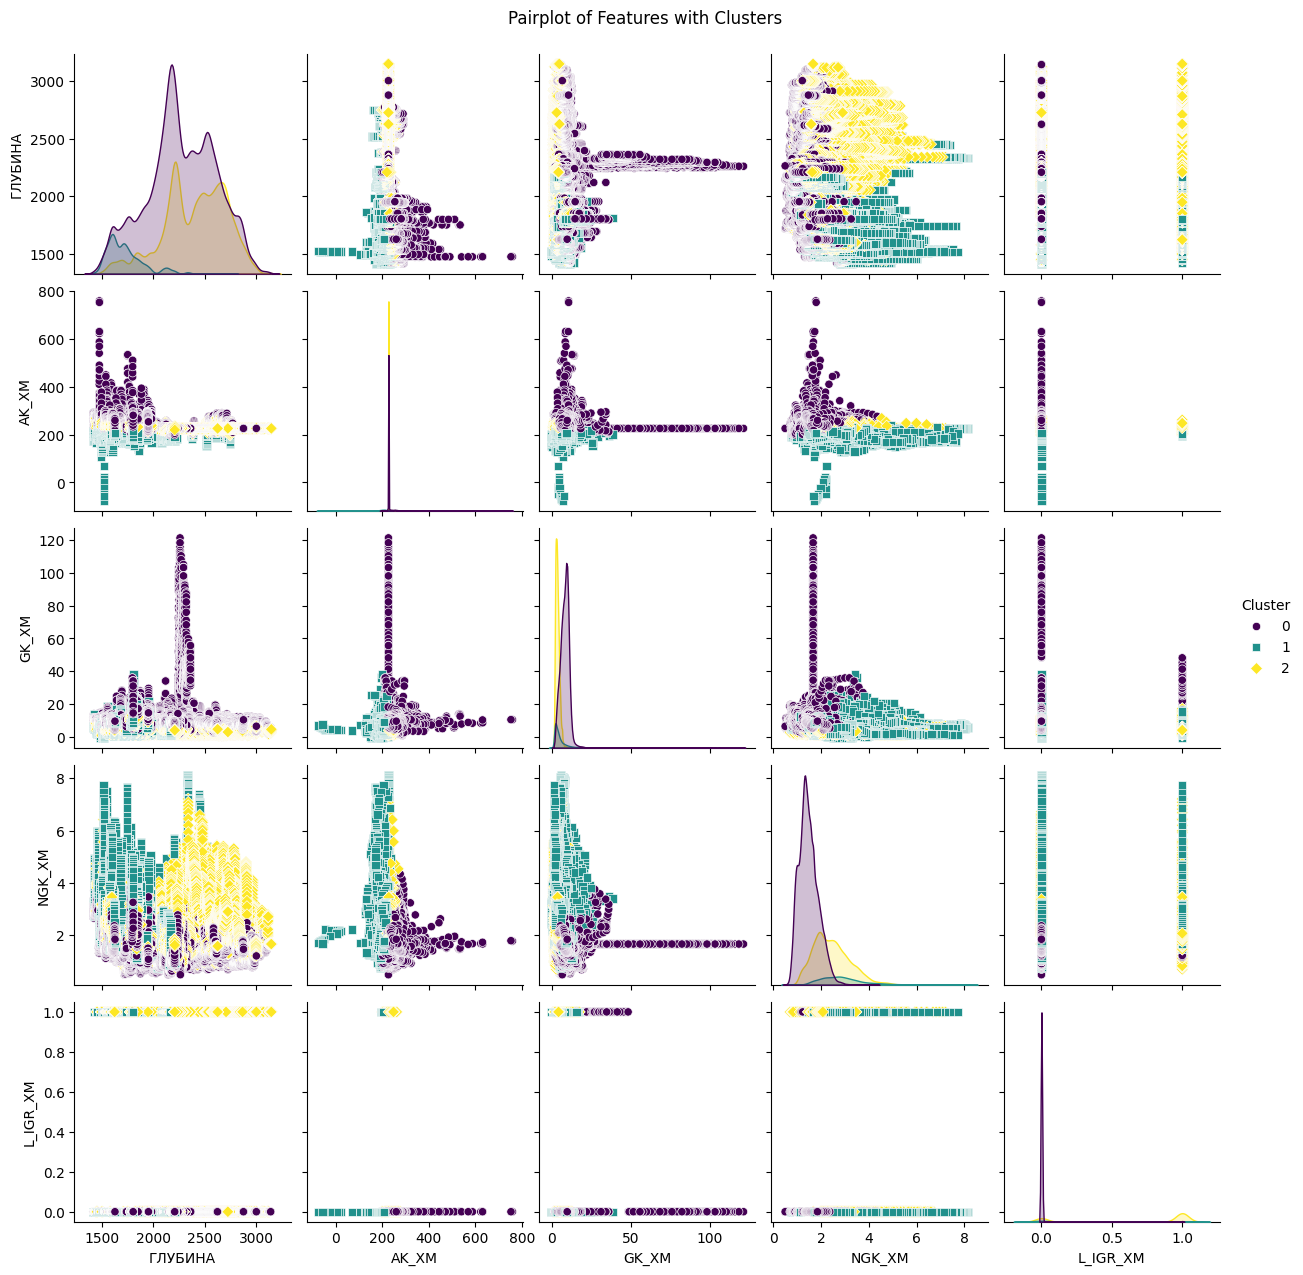

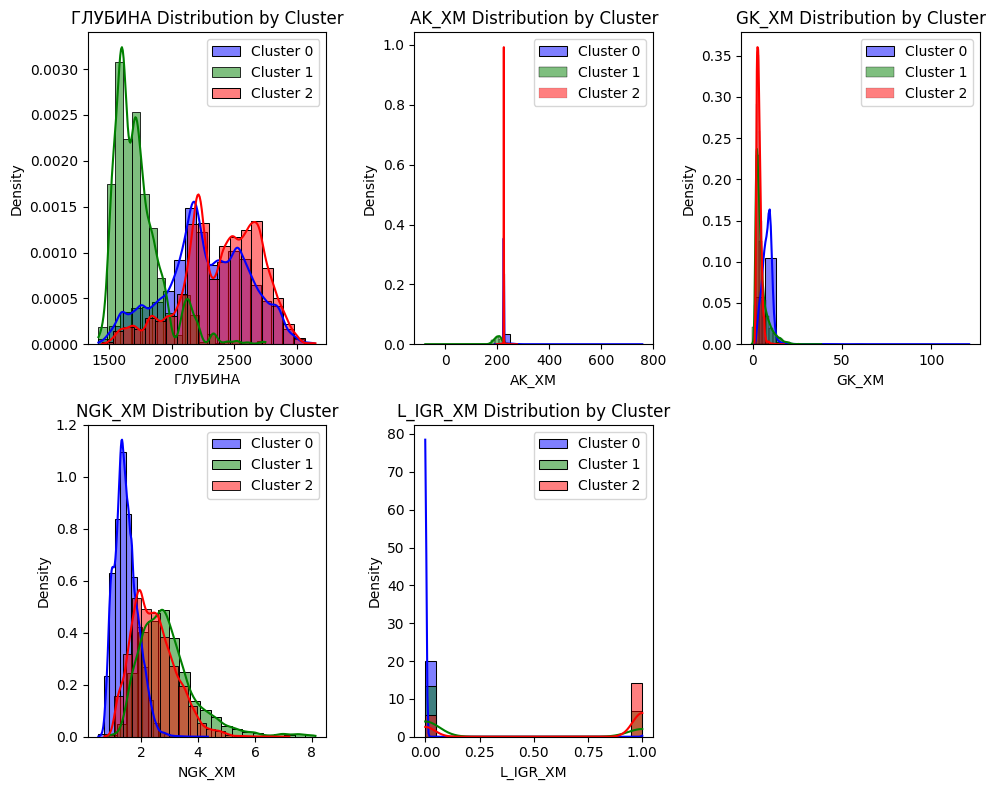

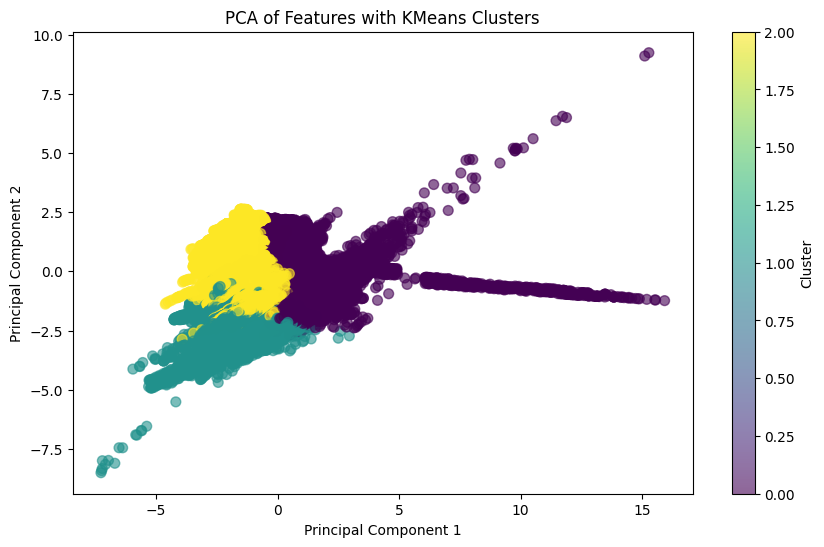

In [37]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка и подготовка данных (предполагается, что df уже загружен и подготовлен)
# Например, если df не загружен, можно использовать следующий код для его загрузки:
# df = pd.read_csv('путь_к_файлу.csv')

# Убедитесь, что данные не содержат пропусков в столбцах, которые будут использоваться
# Включаем только необходимые признаки для кластеризации
features = ["ГЛУБИНА", "AK_XM", "GK_XM", "NGK_XM", "L_IGR_XM"]

# Извлекаем только эти признаки
X = df[features]

# Стандартизируем данные, чтобы признаки имели одинаковый масштаб
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Применяем K-Means кластеризацию с заданным количеством кластеров (например, 3)
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Выводим информацию о кластерах
print("Информация по кластерам:")
print(df[['well', 'Cluster']].groupby('Cluster').agg(list))

# Оценка качества кластеризации
sil_score = silhouette_score(X_scaled, df['Cluster'])
print(f"Silhouette Score: {sil_score:.3f}")

# Визуализация всех признаков
# Для визуализации различных пар признаков будем использовать seaborn
sns.pairplot(df, hue="Cluster", vars=features, palette="viridis", markers=["o", "s", "D"])
plt.suptitle('Pairplot of Features with Clusters', y=1.02)
plt.show()

# Визуализируем распределение признаков по кластерам
plt.figure(figsize=(10, 8))

# Для каждого признака строим гистограмму для разных кластеров
for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[df['Cluster'] == 0][feature], kde=True, color='blue', label='Cluster 0', stat="density", bins=20)
    sns.histplot(df[df['Cluster'] == 1][feature], kde=True, color='green', label='Cluster 1', stat="density", bins=20)
    sns.histplot(df[df['Cluster'] == 2][feature], kde=True, color='red', label='Cluster 2', stat="density", bins=20)
    plt.title(f'{feature} Distribution by Cluster')
    plt.legend()

plt.tight_layout()
plt.show()

# Визуализируем результаты кластеризации с использованием всех признаков
# Поскольку у нас больше 2 признаков, мы можем использовать PCA для снижения размерности до 2 для визуализации

from sklearn.decomposition import PCA

# Применим PCA для снижения размерности
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Визуализируем PCA
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], cmap='viridis', s=50, alpha=0.6)

# Добавим подписи
plt.title('PCA of Features with KMeans Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Покажем график
plt.colorbar(scatter, label='Cluster')
plt.show()


In [38]:
# Сохраняем DataFrame с кластерами в CSV в корневую директорию проекта
output_file_path = os.path.join(os.getcwd(), 'clustered_wells.csv')
df.to_csv(output_file_path, index=False)
print("Итоговый файл с кластерами сохранён в корневую директорию проекта.")


Итоговый файл с кластерами сохранён.


Кластеризация на агрегированных данных. Скважина будет иметь 1 значение кластера.  K-Means.

Информация по кластерам:
                                                      well
Cluster                                                   
0        [763, 764, 765, 803, 808, 841, 843, 844, 845, ...
1        [806, 842, 846, 848, 849, 2006, 2007, 2008, 20...
2        [2193, 3006, 3008, 2002, 2022, 2026_pl, 2200, ...
Silhouette Score: 0.309


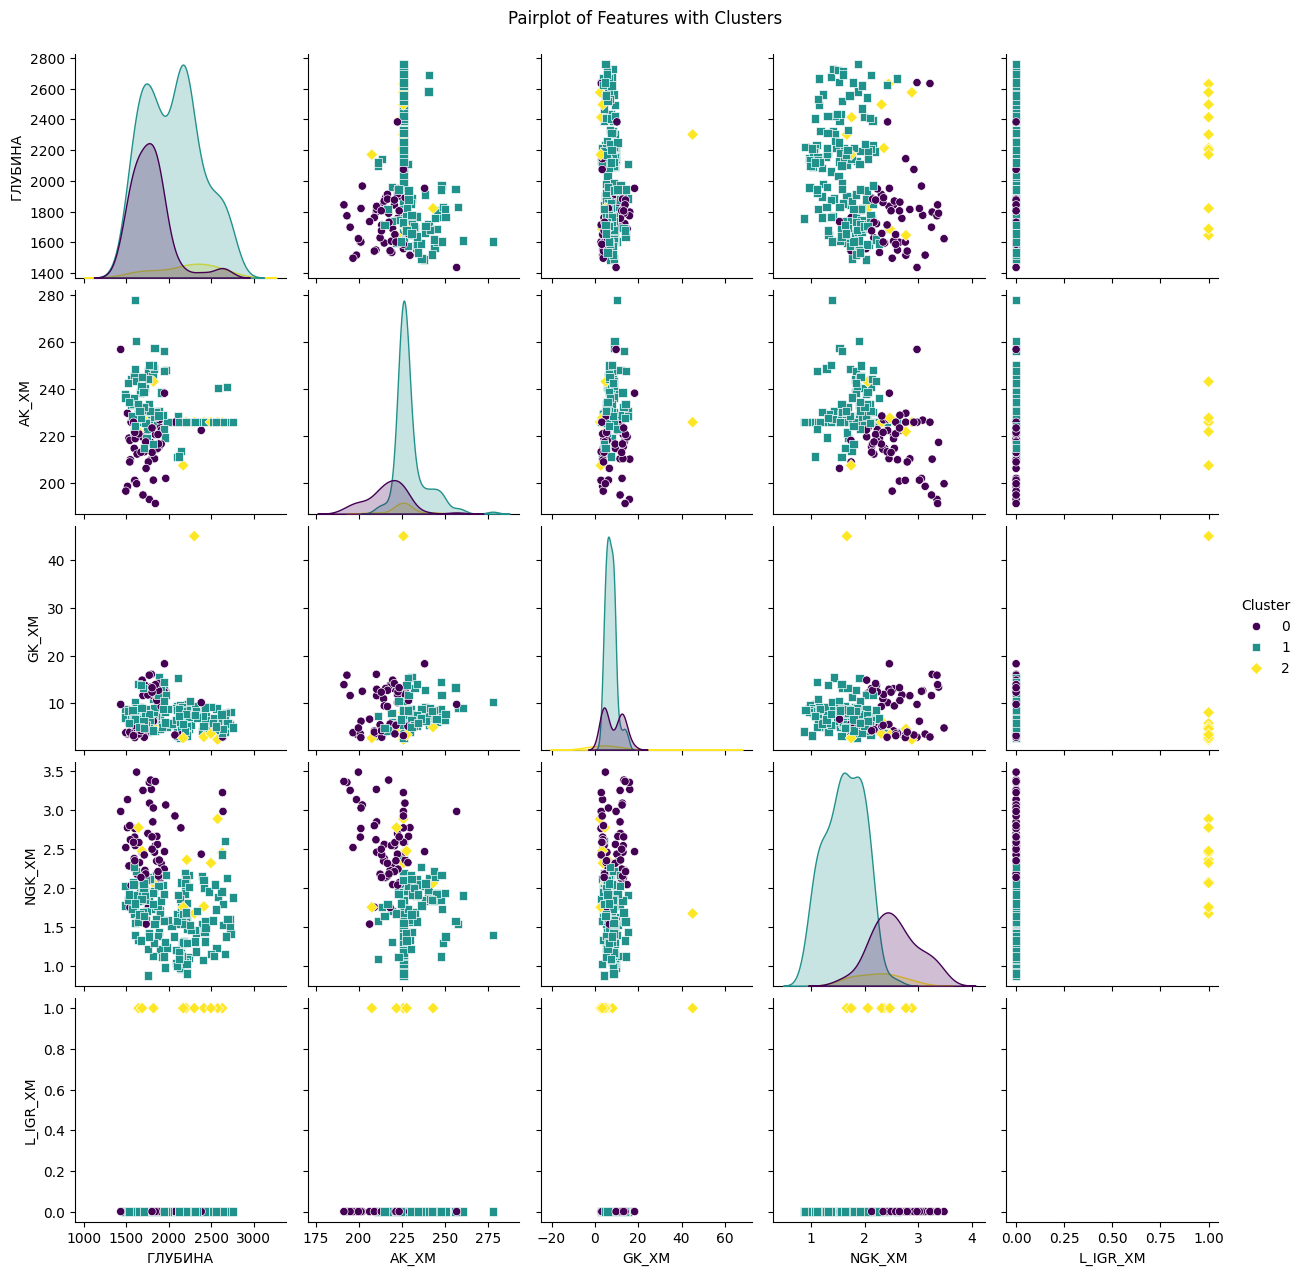

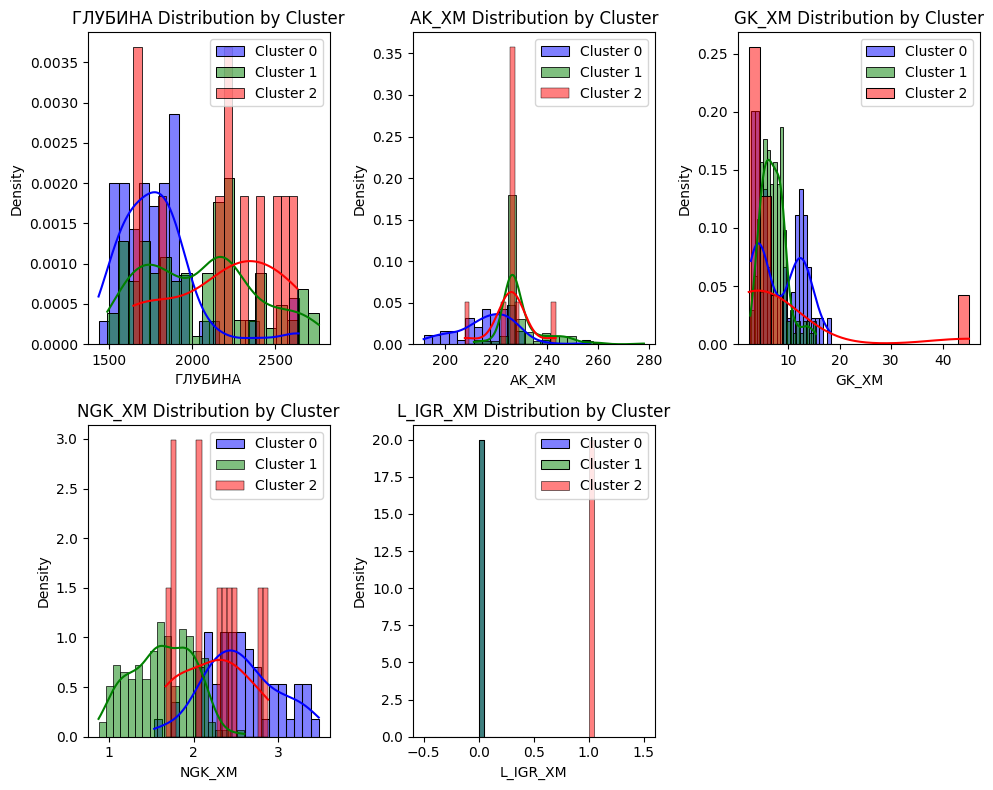

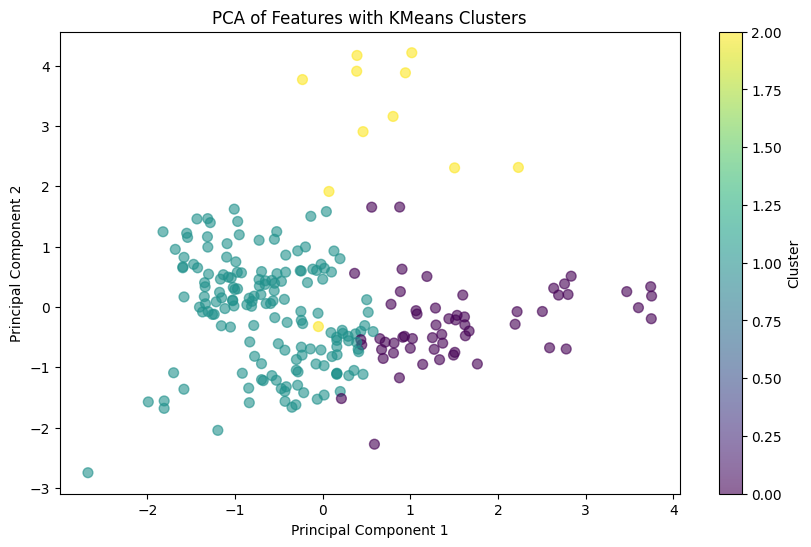

In [39]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Предположим, что df уже загружен и подготовлен

# Шаг 1: Агрегируем данные по скважинам
features = ["ГЛУБИНА", "AK_XM", "GK_XM", "NGK_XM", "L_IGR_XM"]

# Группируем данные по имени скважины ('well') и вычисляем медиану для каждого признака
aggregated_df = df.groupby('well')[features].agg('median').reset_index()

# Шаг 2: Стандартизируем данные, чтобы признаки имели одинаковый масштаб
scaler = StandardScaler()
X_scaled = scaler.fit_transform(aggregated_df[features])

# Шаг 3: Применяем K-Means кластеризацию с заданным количеством кластеров (например, 3)
kmeans = KMeans(n_clusters=3, random_state=42)
aggregated_df['Cluster'] = kmeans.fit_predict(X_scaled)

# Выводим информацию по кластерам
print("Информация по кластерам:")
print(aggregated_df[['well', 'Cluster']].groupby('Cluster').agg(list))

# Оценка качества кластеризации
sil_score = silhouette_score(X_scaled, aggregated_df['Cluster'])
print(f"Silhouette Score: {sil_score:.3f}")

# Шаг 4: Визуализация всех признаков с кластеризацией

# Для визуализации различных пар признаков будем использовать seaborn
sns.pairplot(aggregated_df, hue="Cluster", vars=features, palette="viridis", markers=["o", "s", "D"])
plt.suptitle('Pairplot of Features with Clusters', y=1.02)
plt.show()

# Визуализируем распределение признаков по кластерам
plt.figure(figsize=(10, 8))

# Для каждого признака строим гистограмму для разных кластеров
for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(aggregated_df[aggregated_df['Cluster'] == 0][feature], kde=True, color='blue', label='Cluster 0', stat="density", bins=20)
    sns.histplot(aggregated_df[aggregated_df['Cluster'] == 1][feature], kde=True, color='green', label='Cluster 1', stat="density", bins=20)
    sns.histplot(aggregated_df[aggregated_df['Cluster'] == 2][feature], kde=True, color='red', label='Cluster 2', stat="density", bins=20)
    plt.title(f'{feature} Distribution by Cluster')
    plt.legend()

plt.tight_layout()
plt.show()

# Шаг 5: Визуализируем результаты кластеризации с использованием PCA для снижения размерности до 2
# Поскольку у нас больше 2 признаков, мы применим PCA для снижения размерности до 2 для визуализации

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Визуализируем PCA
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=aggregated_df['Cluster'], cmap='viridis', s=50, alpha=0.6)

# Добавим подписи
plt.title('PCA of Features with KMeans Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Покажем график
plt.colorbar(scatter, label='Cluster')
plt.show()


In [ ]:
# Шаг 6: Запись результатов в CSV файл
output_file_path = os.path.join(os.getcwd(),'aggregated_clusters.csv'
aggregated_df.to_csv(output_file_path, index=False)

print(f"Результаты кластеризации сохранены в файл: {output_file_path}")

Кластеризация на агрегированных данных. Скважина будет иметь 1 значение кластера.  DBSCAN и Agglomerative Clustering

Silhouette Score для K-Means: 0.309
Silhouette Score для DBSCAN: -0.098
Silhouette Score для Agglomerative Clustering: 0.264
Silhouette Score для GMM: 0.275


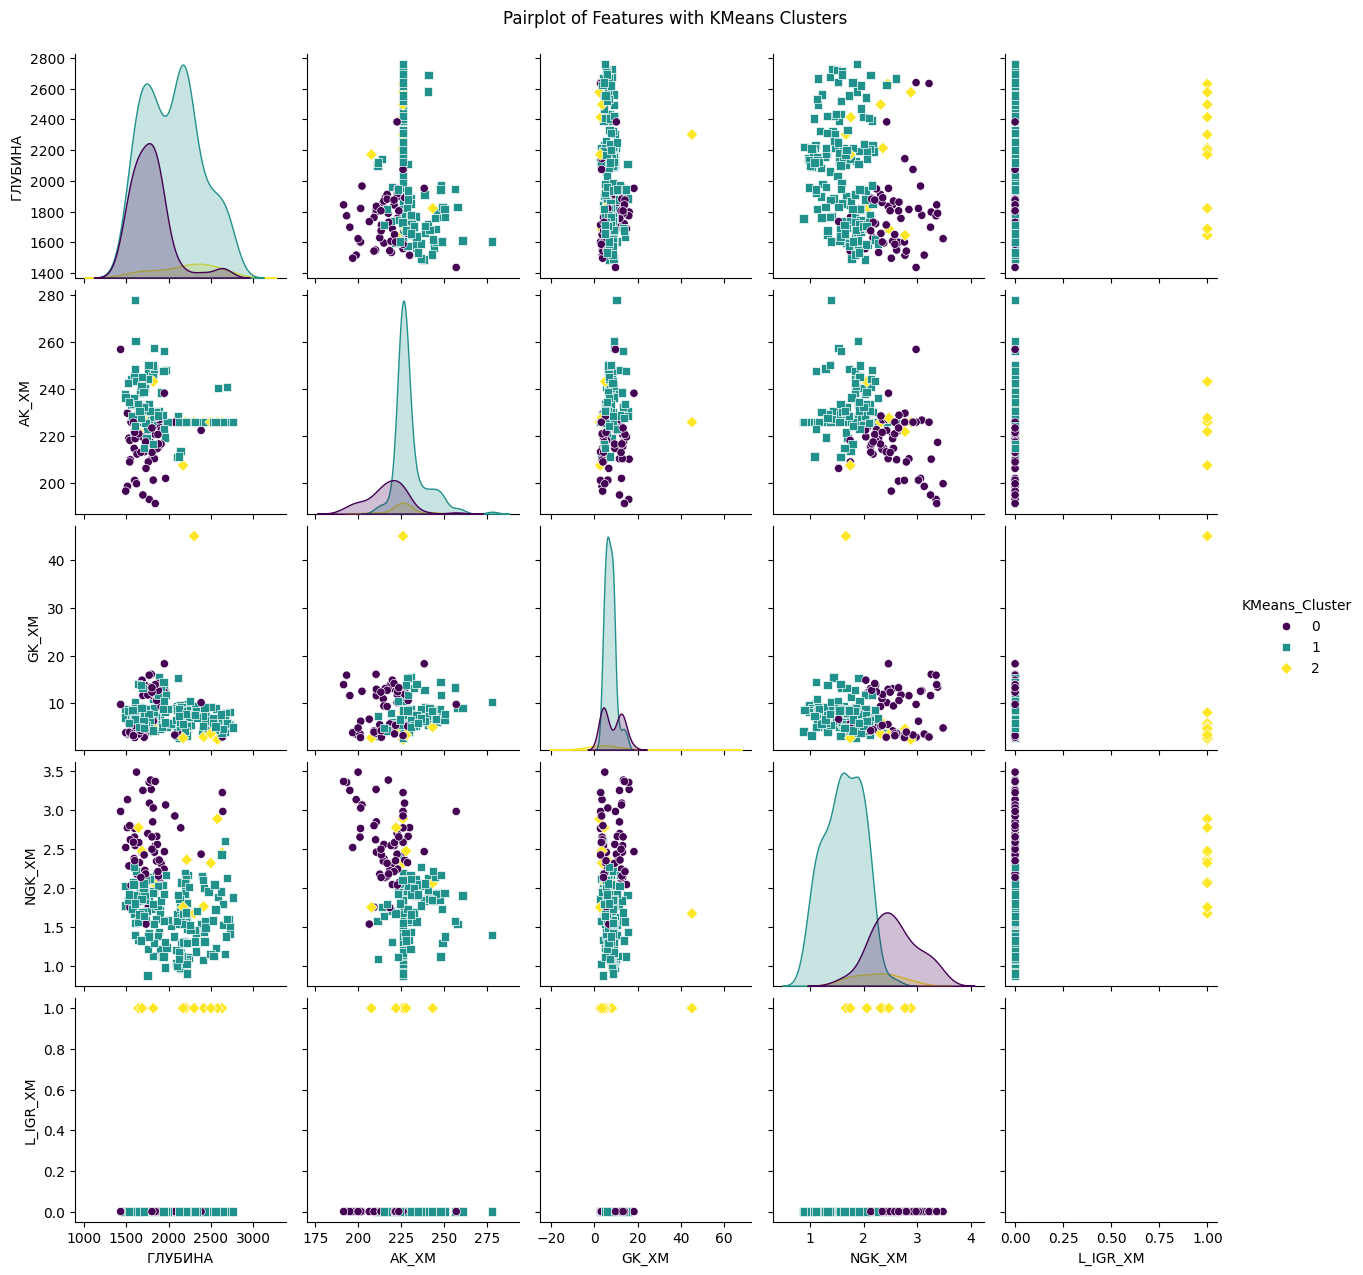

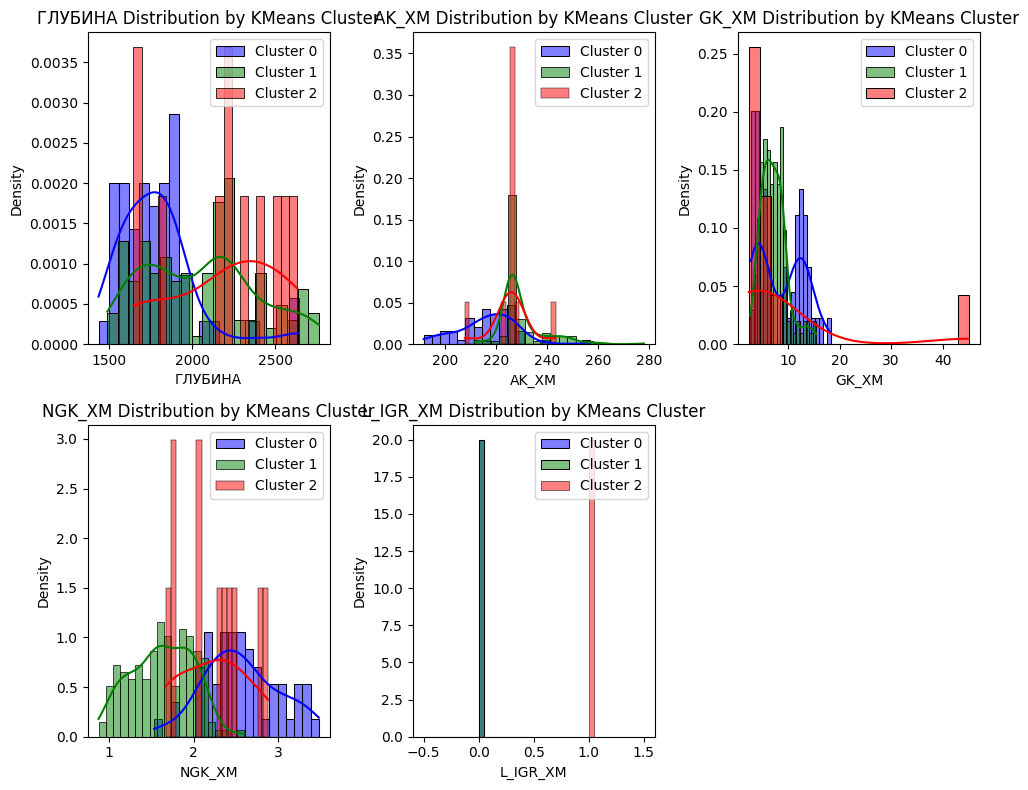

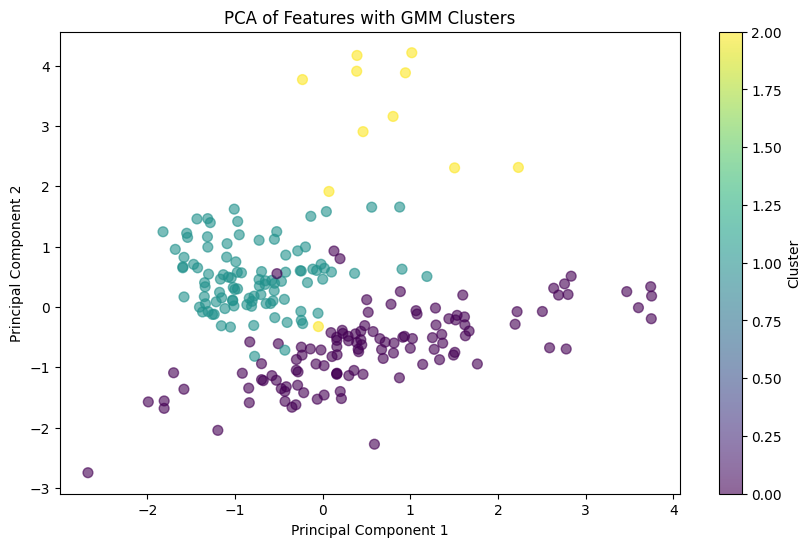

Результаты кластеризации сохранены в файл: C:\МЫС\ML_CH\Classific_XM\aggregated_clusters.csv


In [41]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Предположим, что df уже загружен и подготовлен

# Шаг 1: Агрегируем данные по скважинам
features = ["ГЛУБИНА", "AK_XM", "GK_XM", "NGK_XM", "L_IGR_XM"]

# Группируем данные по имени скважины ('well') и вычисляем медиану для каждого признака
aggregated_df = df.groupby('well')[features].agg('median').reset_index()

# Шаг 2: Стандартизируем данные, чтобы признаки имели одинаковый масштаб
scaler = StandardScaler()
X_scaled = scaler.fit_transform(aggregated_df[features])

# Применяем различные алгоритмы кластеризации и оцениваем качество

# 1. K-Means кластеризация
kmeans = KMeans(n_clusters=3, random_state=42)
aggregated_df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)
kmeans_silhouette = silhouette_score(X_scaled, aggregated_df['KMeans_Cluster'])
print(f"Silhouette Score для K-Means: {kmeans_silhouette:.3f}")

# 2. DBSCAN кластеризация
dbscan = DBSCAN(eps=0.5, min_samples=5)
aggregated_df['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)
dbscan_silhouette = silhouette_score(X_scaled, aggregated_df['DBSCAN_Cluster']) if len(set(aggregated_df['DBSCAN_Cluster'])) > 1 else -1
print(f"Silhouette Score для DBSCAN: {dbscan_silhouette:.3f}")

# 3. Agglomerative Clustering (Иерархическая кластеризация)
agg_clust = AgglomerativeClustering(n_clusters=3)
aggregated_df['Agglomerative_Cluster'] = agg_clust.fit_predict(X_scaled)
agg_clust_silhouette = silhouette_score(X_scaled, aggregated_df['Agglomerative_Cluster'])
print(f"Silhouette Score для Agglomerative Clustering: {agg_clust_silhouette:.3f}")

# 4. Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=3, random_state=42)
aggregated_df['GMM_Cluster'] = gmm.fit_predict(X_scaled)
gmm_silhouette = silhouette_score(X_scaled, aggregated_df['GMM_Cluster'])
print(f"Silhouette Score для GMM: {gmm_silhouette:.3f}")

# Визуализация кластеров

# Для визуализации различных пар признаков будем использовать seaborn
sns.pairplot(aggregated_df, hue="KMeans_Cluster", vars=features, palette="viridis", markers=["o", "s", "D"])
plt.suptitle('Pairplot of Features with KMeans Clusters', y=1.02)
plt.show()

# Визуализируем распределение признаков по кластерам для K-Means
plt.figure(figsize=(10, 8))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(aggregated_df[aggregated_df['KMeans_Cluster'] == 0][feature], kde=True, color='blue', label='Cluster 0', stat="density", bins=20)
    sns.histplot(aggregated_df[aggregated_df['KMeans_Cluster'] == 1][feature], kde=True, color='green', label='Cluster 1', stat="density", bins=20)
    sns.histplot(aggregated_df[aggregated_df['KMeans_Cluster'] == 2][feature], kde=True, color='red', label='Cluster 2', stat="density", bins=20)
    plt.title(f'{feature} Distribution by KMeans Cluster')
    plt.legend()
plt.tight_layout()
plt.show()

# Визуализируем PCA для кластеров GMM
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=aggregated_df['GMM_Cluster'], cmap='viridis', s=50, alpha=0.6)
plt.title('PCA of Features with GMM Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Шаг 5: Запись результатов в CSV файл
output_file_path = r'C:\МЫС\ML_CH\Classific_XM\aggregated_clusters.csv'
aggregated_df.to_csv(output_file_path, index=False)

print(f"Результаты кластеризации сохранены в файл: {output_file_path}")
